Name - Alsafa Sayyad

Div - B

Roll no. - BSC23DS144

#Airline Passanger Forecasting

OBJECTIVE:-

To forecast the number of airline passengers for efficient resource planning and demand management by airline companies.

CONCEPT:-

Air passenger data is a classic time series problem exhibiting trend (growth in air travel) and seasonality (peaks in holidays or vacations). The dataset (like the "AirPassengers" dataset) is used with ARIMA, SARIMA, or Holt-Winters Exponential Smoothing for accurate forecasting. Decomposing the series helps understand yearly trends and patterns in passenger demand

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data
df = pd.read_csv('/content/AirPassengers.csv')
df.columns = ['Month', 'Passengers']
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Normalize the passenger numbers
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Passengers']])

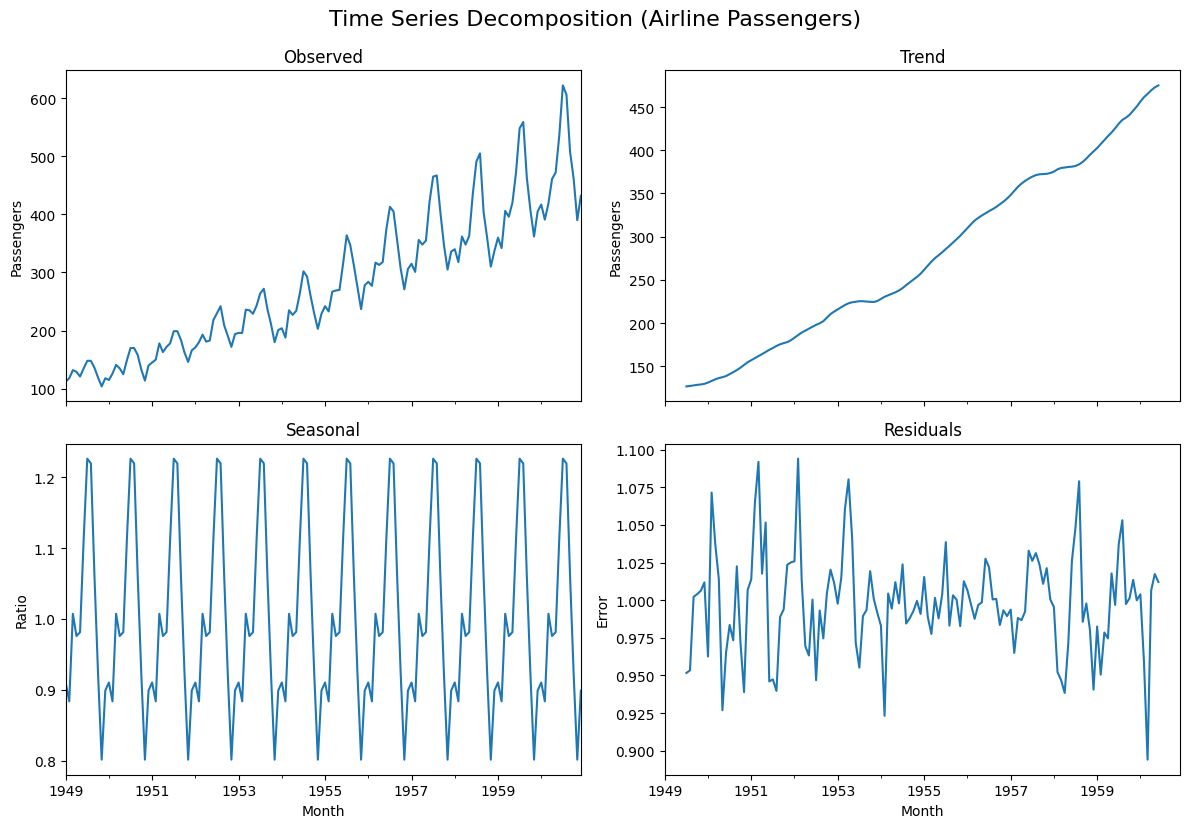

In [17]:
# Decompose
result = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

# Plot in 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Observed
result.observed.plot(ax=axes[0, 0], title='Observed')
axes[0, 0].set_ylabel('Passengers')

# Trend
result.trend.plot(ax=axes[0, 1], title='Trend')
axes[0, 1].set_ylabel('Passengers')

# Seasonal
result.seasonal.plot(ax=axes[1, 0], title='Seasonal')
axes[1, 0].set_ylabel('Ratio')

# Residual
result.resid.plot(ax=axes[1, 1], title='Residuals')
axes[1, 1].set_ylabel('Error')

plt.tight_layout()
plt.suptitle("Time Series Decomposition (Airline Passengers)", fontsize=16, y=1.03)
plt.show()


In [18]:
# Create sequences
def create_sequences(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_sequences(scaled_data, time_step)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0596
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0117
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0122
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0083
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0068
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0074
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0062
Epoch 16/100
7/7 ━━━━━━━━━━━━━━

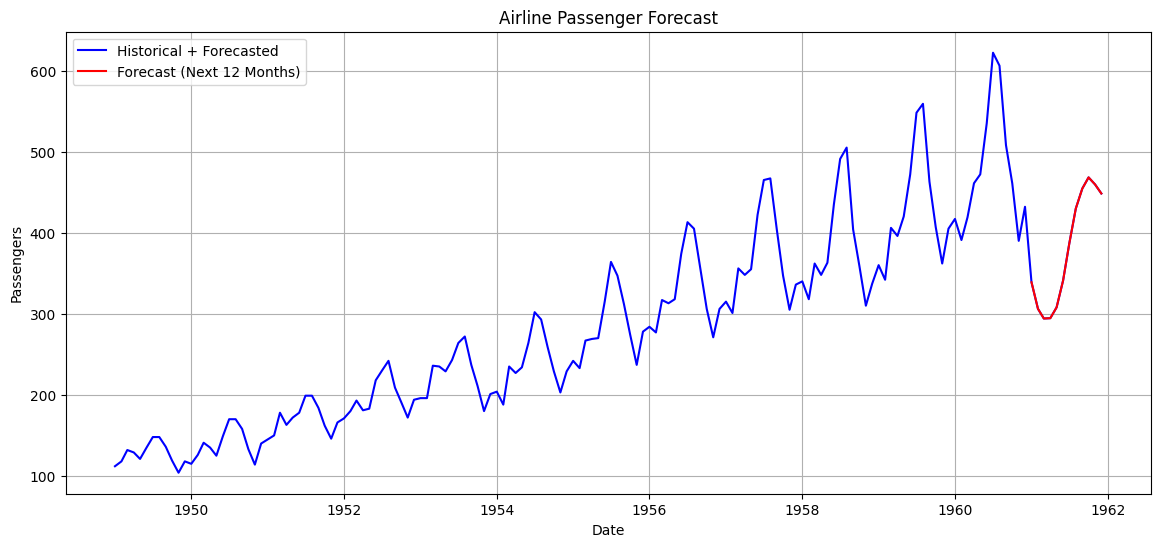

In [6]:
# -----------------------
# Forecast next 12 months
# -----------------------
last_seq = scaled_data[-time_step:]
future_preds = []

for _ in range(12):
    input_seq = last_seq.reshape(1, time_step, 1)
    pred = model.predict(input_seq, verbose=0)
    future_preds.append(pred[0, 0])
    last_seq = np.append(last_seq[1:], pred, axis=0)  # Slide window

# Inverse transform to original scale
future_preds_rescaled = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Concatenate last historical value and future predictions for smoothness
full_dates = df.index.append(future_dates)
full_passengers = np.append(df['Passengers'].values, future_preds_rescaled)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(full_dates, full_passengers, label='Historical + Forecasted', color='blue')
plt.plot(future_dates, future_preds_rescaled, label='Forecast (Next 12 Months)', color='red')
plt.title('Airline Passenger Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

